Today we will have a quick refresher on $L_2$-norm, then you will have the opportunity to do something on your own.

In [1]:
def simplexQuadrature( N, D ):
# Created by Greg von Winckel, translated in Python by Franco Zivcovich.
#
# Original code: 
# https://www.mathworks.com/matlabcentral/fileexchange/9435-n-dimensional-simplex-quadrature
#
# Translation in Julia:
# https://github.com/eschnett/SimplexQuad.jl
#
        def rquad( N, d ):
            #
            cof = 2 * np.array( range( N ) ) + d
            if d:
                A = ( d ** 2 ) / ( cof * ( cof + 2 ) )
            else:
                A = np.zeros( N )
            B = ( cof[1:] ** 2 - d ** 2 ) / ( 2 * cof[1:] * np.sqrt( cof[1:]**2 - 1 ) )
            M = np.diag( A ) + np.diag( B, -1 ) + np.diag( B, 1 )
            #
            x, V = np.linalg.eig( M )
            i = np.argsort( x )
            x = ( x[ i ] + 1 ) / 2
            w = V[ 0,i ]**2 / ( d + 1 )
            return x, w
        #
        X = np.ones( ( N ** D, D + 1 ) )
        W = np.ones( ( N ** D, ) )
        dim = np.ones( D, dtype = 'int32' )
        dim[0] = -1
        for d in range( 1, D + 1 ):
            # cornerstone of this implementation
            x, w = rquad( N, D - d )
            # some auxiliary arrays
            transposition = np.array( range( D ), dtype = 'int32' )
            transposition[ d - 1 ] = 0
            transposition[ 0 ] = d - 1
            tilation = np.ones( D, dtype = 'int32' ) * N
            tilation[ d - 1 ] = 1
            # create the structures you need
            x = np.transpose( x.reshape( dim ), transposition )
            w = np.transpose( w.reshape( dim ), transposition )
            # build X and W
            X[ :,d ] = X[ :,d-1 ] * np.tile( x, tilation ).reshape( -1, order = 'F' )
            W        = W          * np.tile( w, tilation ).reshape( -1, order = 'F' )

        # manipulate output
        X = - np.diff( X,1,1 )
        permutation = np.roll( np.array( range( D ), dtype = 'int32' ),1 )
        X = X[:,permutation]

        return X, W

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# the function that we want to "quadrate"
fun = lambda x : np.sin( x * np.pi )

# branches of the basis function on the reference element
phi = lambda x : np.array([ 1 - x, x ])

Nv = 16 # number of vertices
Nc = Nv - 1 # number of elements (one less than vertices in 1D ofc)

# domain: [a,b]
a = 0
b = 2

# fit data to our template
Points = np.linspace( a,b,Nv )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B      = np.transpose( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:], ( 0, 2, 1 ) )
dtB    = np.linalg.det( B ) # ofc this is dumb in 1D

d = 1

# evaluation of the function at vertices
c = fun( Points ).reshape(-1)

Now, only for plotting/evaluation purposes we define the following quantities.

In [18]:
# these are in the reference element
points_in_refelem        = np.linspace( 0, 1, 19 ) # why 19? bcause it's a number you can recognise after hehe
# these are the 2 branches evaluated on the reference element
phi_of_points_in_refelem = phi( points_in_refelem ) 
# these are in the physical elements
points_in_phyelem        = (B @ points_in_refelem[None,:]).reshape(Nv-1,-1) + Points[CList[:,0]] 

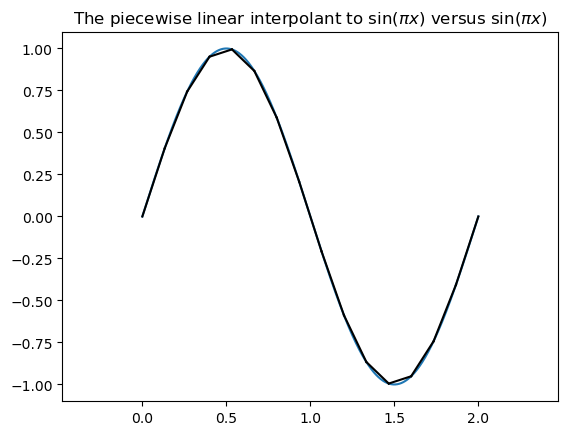

In [19]:
# Plotting
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

# plot fun
xx = np.linspace( a,b,1000 ) 
plt.plot( xx, fun(xx) )
# plot the evaluation of the piecewise linear projection of fun
plt.plot( points_in_phyelem.T, (c[CList] @ phi_of_points_in_refelem).T, 'k' )
plt.title('The piecewise linear interpolant to $\sin(\pi x)$ versus $\sin(\pi x)$')
plt.show()

Let's analyse carefully shapes to get a better grip on this concept!

In [20]:
print( c.shape ) # a function value for each knot! (not surprising right?)
print( Nv )
print(' ')

print( c[CList].shape ) # two function values for each element (one for the left extreme and one for the right one)
print( Nc )
print(' ')

print( phi_of_points_in_refelem.shape ) # the 19 points in reference element [0,1]
print( (c[CList] @ phi_of_points_in_refelem).T.shape ) # what's the meaning of this??

(16,)
16
 
(15, 2)
15
 
(2, 19)
(19, 15)


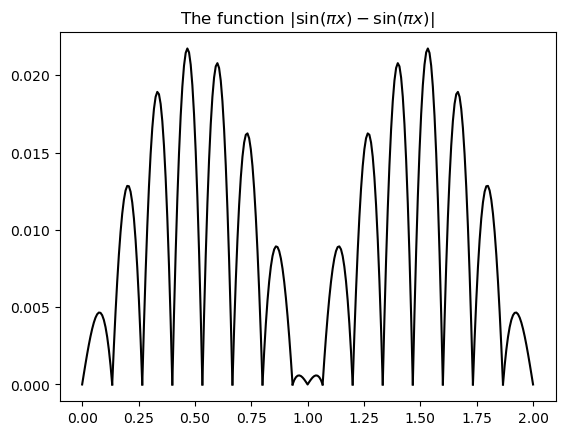

In [22]:
plt.plot( points_in_phyelem.T, np.abs(c[CList] @ phi_of_points_in_refelem - fun( points_in_phyelem )).T, 'k' )
plt.title('The function $|\sin(\pi x) - \sin(\pi x)|$')
plt.show()

Now that we understood how to evaluate our piecewise linear function at any point (not only vertices!!) let's have an exercise.

### Exercise 01:

Compute the $L_2$-norm of 
$$
f(x)-s(x) = f(x) - \sum_{i=1}^{N_v}f(x_i)\varphi_i(x),
$$
that is,
$$
\lvert|f-s\rvert|_2 =
\sqrt{
\int_{[a,b]} 
\bigl(f(x)-s(x)\bigr)^2
\mathrm{d}x
}.
$$

In [23]:
X, W = simplexQuadrature( N = 3, D = 1 ) # quadrature nodes and weights (in refelem)
res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]] # map to physical elementSSSSSSS (plural!!)
    z = fun( p ) - c[CList] @ phi( X[q,:] ) # how come we evaluated phi at a reference element point?
    res = res + z**2 * W[q] * dtB[:,None] # as always, z**2 <-> (f(x)-s(x))^2, quadrature weight and jacobian
normL2 = np.sqrt( res.sum() )
print( normL2 )

0.015956791238479307


In formulas, this amounts to
$$
\lvert|f-s\rvert|_2
\approx
\sqrt{
\sum_{k = 1}^{N_c}
\sum_{q = 1}^{N_q}
\biggl(
\biggl(
f(F_k(x_q)) - \sum_{i=1}^{N_v}f(x_i)\varphi_i(F_k(x_q))%\widehat
\biggr)
w_q
|B_k|
%\text{det}(B_k)
\biggr)^2
}.
$$

### Remark

How come that instead in the code we evaluated ```phi``` at reference element points and not at the physical elements ones?

Well, the branches of ```phi``` equal 1 at one vertex (to each its own ofc) and zero at the others. This is true in the reference element as much as it is in the physical element therefore evaluating the physical ```phi``` at twin locations to reference element points is equivalent to evaluating the reference ```phi``` at the reference element points.

In other words, in the $k$th element we have

```phi( X[q,:] ) == phi( np.linalg.inv( B[k,:,:] ) @ ( p[k,:] - Points[CList[k,0]] ))```,

I wanted to stress this by showing it empirically in the following:

In [25]:
X, W = simplexQuadrature( N = 3, D = 1 )

res = 0
for q in range(W.size):
    for k in range( Nc ):
        p = B[k,:,:] @ X[q,:] + Points[CList[k,0]] # map to physical elementS
        z = fun( p ) - c[CList[k,:]] @ phi( X[q,:] ) # evaluation of phi at reference element point
        res = res + z**2 * W[q] * dtB[k] # squaring and blah blah
normL2 = np.sqrt( res.sum() )
print( normL2 )

res = 0
for q in range(W.size):
    for k in range( Nc ):
        p = B[k,:,:] @ X[q,:] + Points[CList[k,0]] # map to physical elementS
        z = fun( p ) - c[CList[k,:]] @ phi( np.linalg.inv( B[k,:,:] ) @ ( p - Points[CList[k,0]] )) # evaluation of physical phi at reference element point's twin in kth physical element
        res = res + z**2 * W[q] * dtB[k] # squaring and blah blah
normL2 = np.sqrt( res.sum() )
print( normL2 )

0.015956791238479307
0.015956791238479314


In higher dimension nothing changes because we worked _smart_.

Now that you master the art of numerical quadrature I let you solve the following exercise:

### Exercise 02:

Compute the $H_1$-norm of 
$$
f(x)-s(x) = f(x) - \sum_{i=1}^{N_v}f(x_i)\varphi_i(x),
$$
that is,
$$
\lvert|f-s\rvert|_2 + \lvert|f'-s'\rvert|_2 .
%=
%\sqrt{
%\int_{[a,b]} 
%(f(x)-s(x))^2
%\mathrm{d}x
%}
$$

***Warning!!!***

Be real careful to this: when we evaluate the ***derivative*** of ```phi``` (for computing the $H_1$ norm) at reference element points instead of the physical ones we have to bear in mind the chain rule and pull out ```np.linalg.inv( B[k,:,:] )``` for each element ```k```.


Without loops of course... Buon lavoro!